<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/LIME_IMAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation and download

In [50]:
!pip -q install lime
!git clone https://github.com/mobarakol/AI_Medical_Imaging.git
%cd AI_Medical_Imaging

Cloning into 'AI_Medical_Imaging'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 67 (delta 26), reused 17 (delta 2), pack-reused 0
Receiving objects: 100% (67/67), 4.73 MiB | 8.99 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/AI_Medical_Imaging


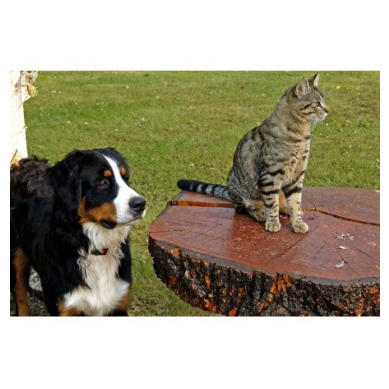

In [51]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import requests

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

img_url = 'https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/dogs.png?raw=true'
img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
plt.imshow(img)
plt.axis('OFF');

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [54]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

#Load label texts for ImageNet predictions so we know what model is predicting
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

Load the pretrained model for Resnet50 available in Pytorch.

In [53]:
model = models.inception_v3(pretrained=True)
model.eval()
img_t = get_input_tensors(img)
logits = model(img_t)

probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


((0.93593, 239, 'Bernese_mountain_dog'),
 (0.03844778, 241, 'EntleBucher'),
 (0.023756443, 240, 'Appenzeller'),
 (0.0018181764, 238, 'Greater_Swiss_Mountain_dog'),
 (9.113307e-06, 214, 'Gordon_setter'))

LIME in Image Classification

  0%|          | 0/1000 [00:00<?, ?it/s]

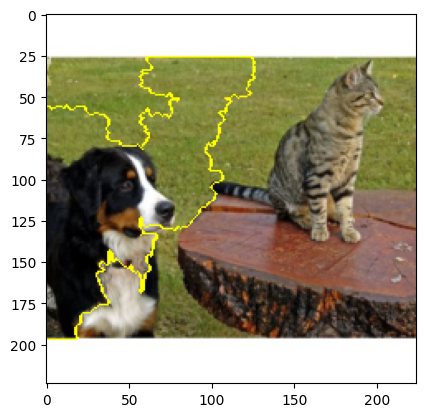

In [58]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification fun

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

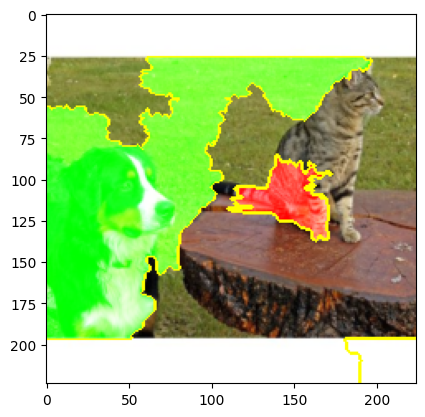

In [59]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)